# Build CNN

In [74]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed
from keras import regularizers


# for working with audio data
import librosa, librosa.display

## Data Preparation

In [2]:
# load metadata csv
df = pd.read_csv('../../Data/features_30_sec.csv')
df = df[['filename', 'label']]

# relative path to the directory of audio file genre subfolders
rel_path = '../../Data/genres_original/'

# create relative path to each audio file
df['file_path'] = rel_path + df['label'] + '/' + df['filename']

# drop 'filename' column
df = df.drop(columns='filename')
df.head()

label                                         file_path
0  blues  ../../Data/genres_original/blues/blues.00000.wav
1  blues  ../../Data/genres_original/blues/blues.00001.wav
2  blues  ../../Data/genres_original/blues/blues.00002.wav
3  blues  ../../Data/genres_original/blues/blues.00003.wav
4  blues  ../../Data/genres_original/blues/blues.00004.wav

In [5]:
# this jazz song is corrupted and will be removed
# y, sr = librosa.load(df['file_path'][554])

In [6]:
# drop the corrupted song
df = df.drop(labels=554)

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      999 non-null    object
 1   file_path  999 non-null    object
dtypes: object(2)
memory usage: 23.4+ KB


In [7]:
# instantiate, fit, transform multiclass target
le = LabelEncoder()
y = le.fit_transform(df['label'])

# one hot encode multiclass target
output_shape = df['label'].nunique()
y = keras.utils.to_categorical(y, output_shape)

# check shape
y.shape

(999, 10)

In [8]:
# split into a 10% holdout set
X_t, X_hold, y_t, y_hold = train_test_split(df['file_path'], y, random_state=42, stratify=y, test_size=0.1)

# split into 75% train, 15% test sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, random_state=42, stratify=y_t, test_size=15/90)

In [9]:
def get_feature(X, sample_duration):
    features = []
    for sample in X:
        try:
            y, sr = librosa.load(sample, duration=sample_duration)
            S_dB = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.min)
            
            # append to the list and create a new axis for concatenation later and one for the single amplitude channel
            features.append(S_dB[np.newaxis,..., np.newaxis])
        except:
            continue

    # concatenate along the first axis; result should be a 4D tensor of shape (#samples, #mels, #frames, #channels)
    return np.concatenate(features,axis=0)

In [10]:
# generate mel spectrograms for train
X_train_mel = get_feature(X_train, 20)
X_train_mel.shape

(749, 128, 862, 1)

In [11]:
# define input shape
input_shape = X_train_mel.shape[1:]

In [12]:
# generate mel spectrograms for test
X_test_mel = get_feature(X_test, 20)

In [13]:
# custom scaling function
def create_min_max_scaler(X_tr):
    X_tr_max = X_tr.max()
    X_tr_min = X_tr.min()
    def custom_scaler(X):
        return (X - X_tr_min) / (X_tr_max - X_tr_min)
    return custom_scaler

In [14]:
# scale all the spectrograms based on train data
min_max_scaler = create_min_max_scaler(X_train_mel)

# apply the scaling to train and test
X_train_mel_scaled = min_max_scaler(X_train_mel)
X_test_mel_scaled = min_max_scaler(X_test_mel)

In [28]:
# fig, ax = plt.subplots(figsize=(10,6))
# S_dB_img = librosa.display.specshow(X_train_mel_scaled[56, :, :, 0], x_axis='time', y_axis='mel', fmax=8000, ax=ax)
# fig.colorbar(S_dB_img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram', ylabel='Mels');

## First Model - Simple Multi-Layer Perceptron

In [ ]:
# build sequentially
first_model = keras.Sequential

## CNN

In [17]:
input_shape

(128, 862, 1)

In [18]:
batch_size = int(X_train_mel_scaled.shape[0]/50)

In [93]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn = keras.Sequential()

# convolutional and max pooling layers with successively more filters
cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn.add(layers.MaxPooling2D((2, 4)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 4)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 4)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(10, activation='softmax'))

# compile cnn
cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 862, 16)      160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 215, 16)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 215, 32)       4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 53, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 13, 128)      

In [94]:
# fit the model
history = cnn.fit(X_train_mel_scaled,
                  y_train,
                  epochs=16,
                  batch_size=batch_size,
                  validation_data=(X_test_mel_scaled, y_test))

Epoch 1/16
54/54 [==============================] - 21s 389ms/step - loss: 2.3067 - accuracy: 0.1041 - val_loss: 2.2878 - val_accuracy: 0.1200
Epoch 2/16
54/54 [==============================] - 21s 397ms/step - loss: 2.2833 - accuracy: 0.1402 - val_loss: 2.1983 - val_accuracy: 0.2000
Epoch 3/16
54/54 [==============================] - 23s 418ms/step - loss: 2.0005 - accuracy: 0.2550 - val_loss: 1.7689 - val_accuracy: 0.2800
Epoch 4/16
54/54 [==============================] - 21s 380ms/step - loss: 1.7592 - accuracy: 0.3351 - val_loss: 1.6937 - val_accuracy: 0.3467
Epoch 5/16
54/54 [==============================] - 15s 277ms/step - loss: 1.5980 - accuracy: 0.3965 - val_loss: 1.5524 - val_accuracy: 0.4400
Epoch 6/16
54/54 [==============================] - 15s 279ms/step - loss: 1.5153 - accuracy: 0.4232 - val_loss: 1.5561 - val_accuracy: 0.4000
Epoch 7/16
54/54 [==============================] - 15s 285ms/step - loss: 1.4695 - accuracy: 0.4593 - val_loss: 1.4713 - val_accuracy: 0.4400

In [19]:
# Defining a results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8), sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

Test loss: 1.3462930917739868
Test accuracy: 0.5066666603088379


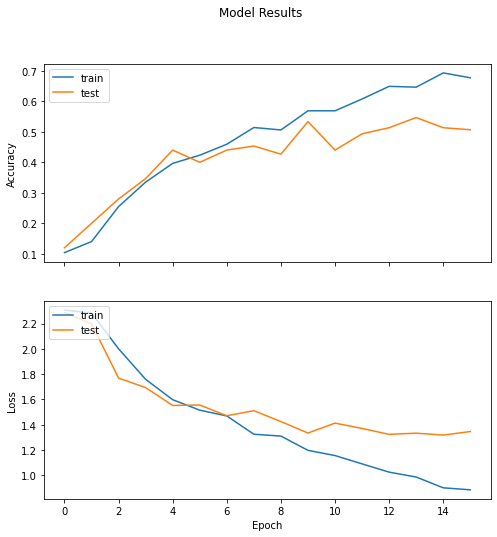

In [103]:
# evaluate
score = cnn.evaluate(X_test_mel_scaled, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

## Iterate

In [36]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn = keras.Sequential()

# convolutional and max pooling layers with successively more filters
cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn.add(layers.MaxPooling2D((2, 4)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 4)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dropout(0.3))
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.3))
cnn.add(layers.Dense(10, activation='softmax'))

# compile cnn
cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 128, 862, 16)      160       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 64, 215, 16)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 215, 32)       4640      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 32, 53, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 26, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 26, 128)      

In [37]:
# fit the model
history = cnn.fit(X_train_mel_scaled,
                  y_train,
                  epochs=40,
                  batch_size=30,
                  validation_data=(X_test_mel_scaled, y_test))

Epoch 1/40
25/25 [==============================] - 12s 470ms/step - loss: 2.3069 - accuracy: 0.0895 - val_loss: 2.3008 - val_accuracy: 0.0933
Epoch 2/40
25/25 [==============================] - 12s 484ms/step - loss: 2.2936 - accuracy: 0.1175 - val_loss: 2.2748 - val_accuracy: 0.1400
Epoch 3/40
25/25 [==============================] - 12s 489ms/step - loss: 2.2734 - accuracy: 0.1575 - val_loss: 2.2975 - val_accuracy: 0.1067
Epoch 4/40
25/25 [==============================] - 12s 487ms/step - loss: 2.2507 - accuracy: 0.1656 - val_loss: 2.1609 - val_accuracy: 0.1867
Epoch 5/40
25/25 [==============================] - 12s 499ms/step - loss: 2.2023 - accuracy: 0.1842 - val_loss: 2.1191 - val_accuracy: 0.2600
Epoch 6/40
25/25 [==============================] - 13s 522ms/step - loss: 2.0985 - accuracy: 0.2390 - val_loss: 2.0033 - val_accuracy: 0.2733
Epoch 7/40
25/25 [==============================] - 13s 502ms/step - loss: 1.9751 - accuracy: 0.2537 - val_loss: 1.8131 - val_accuracy: 0.3467

Test loss: 1.1902085542678833
Test accuracy: 0.5933333039283752


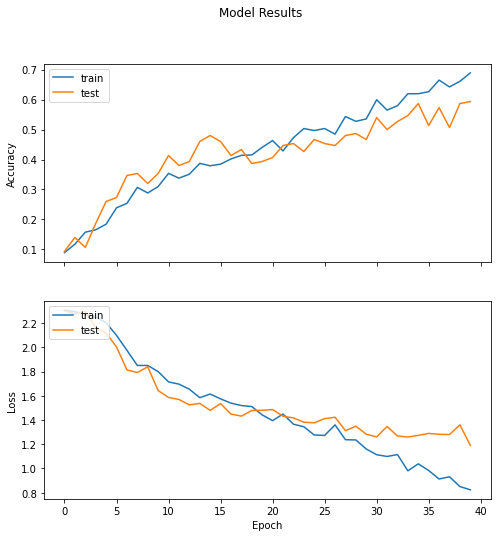

In [38]:
# evaluate
score = cnn.evaluate(X_test_mel_scaled, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

In [30]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn = keras.Sequential()

# convolutional and max pooling layers with successively more filters
cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn.add(layers.MaxPooling2D((2, 4)))

cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 4)))

cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dropout(0.3))
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.3))

# output layer
cnn.add(layers.Dense(10, activation='softmax'))

# compile cnn
cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 862, 16)      160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 215, 16)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 215, 32)       4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 53, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 26, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 26, 128)      

In [31]:
# fit the model
history = cnn.fit(X_train_mel_scaled,
                  y_train,
                  epochs=60,
                  batch_size=30,
                  validation_data=(X_test_mel_scaled, y_test))

Epoch 1/60
25/25 [==============================] - 21s 825ms/step - loss: 2.3069 - accuracy: 0.0895 - val_loss: 2.3008 - val_accuracy: 0.0933
Epoch 2/60
25/25 [==============================] - 17s 697ms/step - loss: 2.2936 - accuracy: 0.1175 - val_loss: 2.2748 - val_accuracy: 0.1400
Epoch 3/60
25/25 [==============================] - 14s 568ms/step - loss: 2.2734 - accuracy: 0.1575 - val_loss: 2.2975 - val_accuracy: 0.1067
Epoch 4/60
25/25 [==============================] - 14s 557ms/step - loss: 2.2507 - accuracy: 0.1656 - val_loss: 2.1609 - val_accuracy: 0.1867
Epoch 5/60
25/25 [==============================] - 16s 653ms/step - loss: 2.2023 - accuracy: 0.1842 - val_loss: 2.1191 - val_accuracy: 0.2600
Epoch 6/60
25/25 [==============================] - 16s 654ms/step - loss: 2.0985 - accuracy: 0.2390 - val_loss: 2.0033 - val_accuracy: 0.2733
Epoch 7/60
25/25 [==============================] - 16s 629ms/step - loss: 1.9751 - accuracy: 0.2537 - val_loss: 1.8131 - val_accuracy: 0.3467

Epoch 58/60
25/25 [==============================] - 17s 661ms/step - loss: 0.3451 - accuracy: 0.8838 - val_loss: 1.4621 - val_accuracy: 0.6267
Epoch 59/60
25/25 [==============================] - 15s 585ms/step - loss: 0.4321 - accuracy: 0.8625 - val_loss: 1.4573 - val_accuracy: 0.6200
Epoch 60/60
25/25 [==============================] - 15s 594ms/step - loss: 0.3630 - accuracy: 0.8705 - val_loss: 1.3819 - val_accuracy: 0.6533


Test loss: 1.3818758726119995
Test accuracy: 0.653333306312561


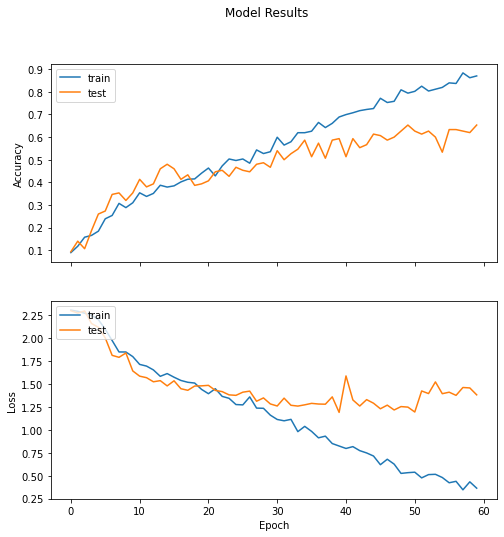

In [32]:
# evaluate
score = cnn.evaluate(X_test_mel_scaled, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

In [127]:
# get predictions on test set
test_preds = cnn.predict(X_test_mel_scaled)

# precision and recall for test set
test_precision = precision_score(np.argmax(y_test, 1), np.argmax(test_preds, 1), average=None)
test_recall = recall_score(np.argmax(y_test, 1), np.argmax(test_preds, 1), average=None)

In [226]:
preds_df = pd.DataFrame(np.concatenate([np.argmax(y_test, 1).reshape(-1, 1),
                                        np.argmax(test_preds, 1).reshape(-1, 1)], axis=1),
                        index=X_test.index,
                        columns=['y', 'preds'])

In [227]:
preds_df['file_path'] = X_test

In [228]:
preds_df['preds'] = preds_df['preds'].map(genre_dict)
preds_df['y'] = preds_df['y'].map(genre_dict)
preds_df.head()

y      preds                                          file_path
148  classical  classical  ../../Data/genres_original/classical/classical...
507       jazz  classical     ../../Data/genres_original/jazz/jazz.00007.wav
751        pop        pop       ../../Data/genres_original/pop/pop.00051.wav
953       rock    country     ../../Data/genres_original/rock/rock.00053.wav
700        pop        pop       ../../Data/genres_original/pop/pop.00000.wav

In [256]:
preds_df[(preds_df['preds'] == 'rock') & (preds_df['y'] == 'rock')]

y preds                                       file_path
917  rock  rock  ../../Data/genres_original/rock/rock.00017.wav
930  rock  rock  ../../Data/genres_original/rock/rock.00030.wav
924  rock  rock  ../../Data/genres_original/rock/rock.00024.wav
907  rock  rock  ../../Data/genres_original/rock/rock.00007.wav
929  rock  rock  ../../Data/genres_original/rock/rock.00029.wav

In [253]:
# pop misclassified as disco example
y, sr = librosa.load(preds_df['file_path'][792], duration=30)
ipd.Audio(y, rate=sr)

In [252]:
# correctly classified disco example
y, sr = librosa.load(preds_df['file_path'][391], duration=30)
ipd.Audio(y, rate=sr)

In [255]:
# blues misclassified as rock example
y, sr = librosa.load(preds_df['file_path'][50], duration=30)
ipd.Audio(y, rate=sr)

In [262]:
# correctly classified rock example
y, sr = librosa.load(preds_df['file_path'][924], duration=30)
ipd.Audio(y, rate=sr)

In [205]:
genre_dict = {ind:genre for ind, genre in enumerate(le.classes_)}

In [148]:
# confusion matrix
confusion = pd.DataFrame(confusion_matrix(np.argmax(y_test, 1), np.argmax(test_preds, 1)),
                         index=le.classes_,
                         columns=le.classes_)

In [149]:
confusion.sort_values('disco', ascending=False)

blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
disco          0          0        2      7       4     0      0    0       0   
pop            0          0        0      3       0     0      0   12       0   
reggae         1          0        1      2       0     0      0    2       9   
blues         10          0        0      1       1     0      0    0       1   
country        2          0        8      1       0     1      0    1       0   
rock           1          1        1      1       0     2      3    1       0   
classical      0         13        0      0       0     0      0    1       1   
hiphop         0          0        0      0       9     0      3    0       3   
jazz           0          3        0      0       0    11      0    0       0   
metal          0          0        0      0       1     0     14    0       0   

           rock  
disco         2  
pop           0  
reggae        0  
blues         2  
country       2  
rock          5  
classical     0  
hiphop        0  
jazz          1  
metal         0

In [172]:
disco_data = confusion.sort_values('disco', ascending=False)['disco']/confusion['disco'].sum()
disco_data = disco_data[disco_data>0]

rock_data = confusion.sort_values('rock', ascending=False)['rock']/confusion['rock'].sum()
rock_data = rock_data[rock_data>0]

<ipython-input-183-770cbf54ee92>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  disco.set_yticklabels(yticklabels)


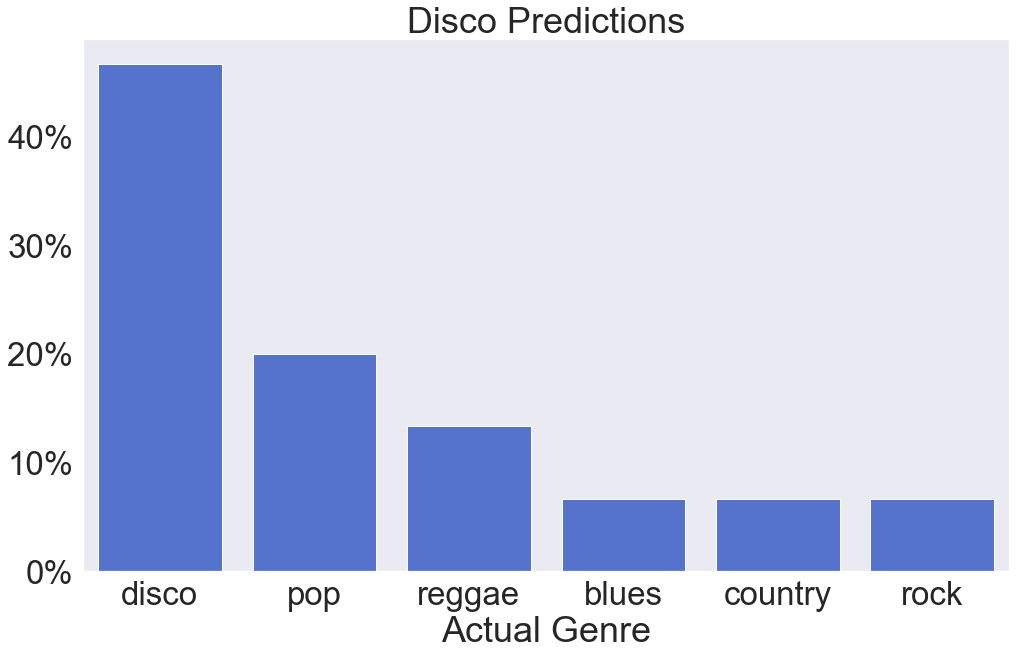

In [183]:
# disco predictions bar plot
sns.set(font_scale=3)
fig, ax = plt.subplots()

disco = sns.barplot(x=disco_data.index,
                    y=disco_data,
                    ax=ax,
                    color='royalblue')

# Customize asthetic
ax.grid(False) # Show the vertical gridlines
disco.set_title("Disco Predictions")
disco.set_xlabel('Actual Genre')
disco.set_ylabel('')

# set yticklabels to be a %
yticklabels = [f'{tick *100:.0f}%' for tick in disco.get_yticks()]
disco.set_yticklabels(yticklabels)

# set tight layout for saving as png
plt.tight_layout()

#save as png
fig.savefig('Disco.png')

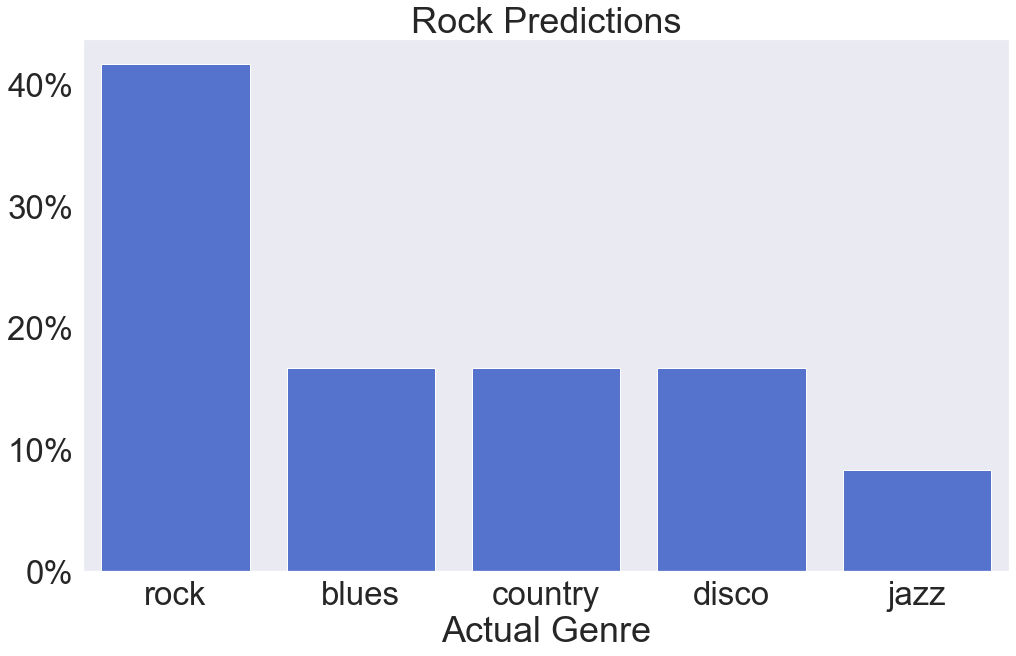

In [181]:
# disco predictions bar plot
sns.set(font_scale=3)
fig, ax = plt.subplots()

rock = sns.barplot(x=rock_data.index,
                    y=rock_data,
                    ax=ax,
                    color='royalblue')

# Customize asthetic
ax.grid(False) # Show the vertical gridlines
rock.set_title("Rock Predictions")
rock.set_xlabel('Actual Genre')
rock.set_ylabel('')
rock.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])

# set yticklabels to be a %
yticklabels = [f'{tick *100:.0f}%' for tick in rock.get_yticks()]
rock.set_yticklabels(yticklabels)

# set tight layout for saving as png
plt.tight_layout()

#save as png
fig.savefig('Rock.png')

In [145]:
data = np.concatenate([test_precision.reshape(-1, 1), test_recall.reshape(-1, 1)], axis=1)

In [146]:
results_df = pd.DataFrame(data, index=le.classes_, columns=['Precision', 'Recall'])

In [147]:
results_df.sort_values('Precision', ascending=False)

Precision    Recall
jazz        0.785714  0.733333
classical   0.764706  0.866667
blues       0.714286  0.666667
pop         0.705882  0.800000
metal       0.700000  0.933333
country     0.666667  0.533333
reggae      0.642857  0.600000
hiphop      0.600000  0.600000
disco       0.466667  0.466667
rock        0.416667  0.333333

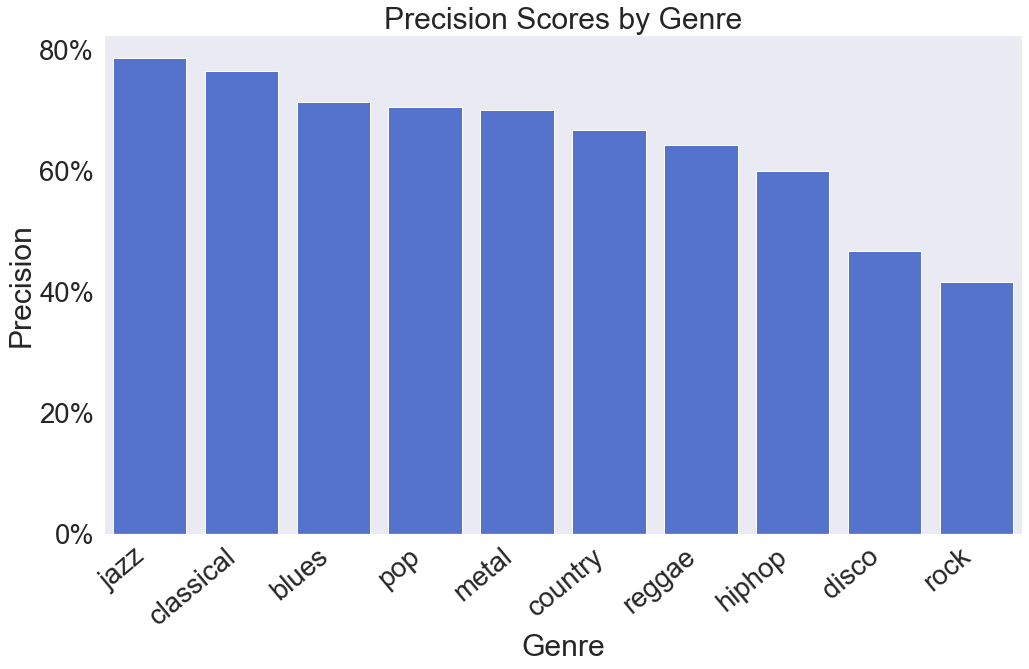

In [176]:
# set style
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(context='talk')
sns.set(font_scale=2.5)

# precision bar plot
fig, ax = plt.subplots()

prec = sns.barplot(data=results_df.sort_values('Precision', ascending=False),
                   x=results_df.sort_values('Precision', ascending=False).index,
                   y='Precision',
                   ax=ax,
                   color='royalblue')

# Customize asthetic
ax.grid(False)
prec.set_xticklabels(prec.get_xticklabels(), rotation = 40, horizontalalignment='right')
prec.set_title("Precision Scores by Genre", fontsize=30)
prec.set_xlabel('Genre')
prec.set_ylabel('Precision')
prec.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])

# set yticklabels to be a %
yticklabels = [f'{tick *100:.0f}%' for tick in prec.get_yticks()]
prec.set_yticklabels(yticklabels)

# set tight layout for saving as png
plt.tight_layout()

#save as png
fig.savefig('Precision.png')

<ipython-input-123-99cac84bb1b3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  rec.set_yticklabels(yticklabels)


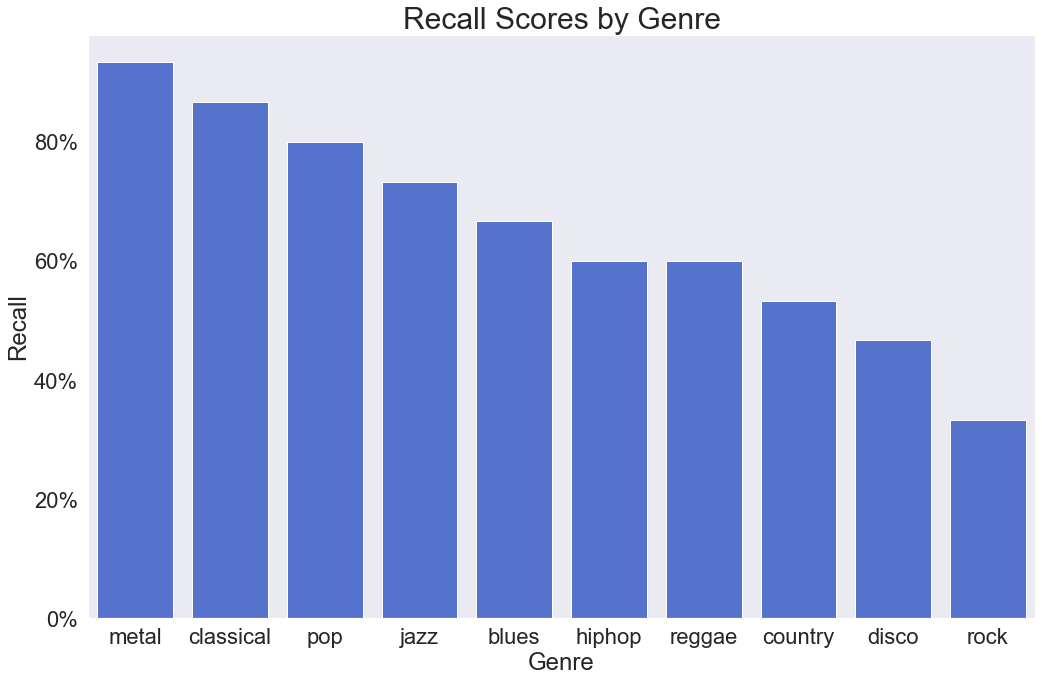

In [123]:
# recall bar plot
fig, ax = plt.subplots()

rec = sns.barplot(data=results_df.sort_values('Recall', ascending=False),
                   x=results_df.sort_values('Recall', ascending=False).index,
                   y='Recall',
                   ax=ax,
                   color='royalblue')

# Customize asthetic
ax.grid(False) # Show the vertical gridlines
rec.set_title("Recall Scores by Genre", fontsize=30)
rec.set_xlabel('Genre')
rec.set_ylabel('Recall')

# set yticklabels to be a %
yticklabels = [f'{tick *100:.0f}%' for tick in rec.get_yticks()]
rec.set_yticklabels(yticklabels)

# set tight layout for saving as png
plt.tight_layout()

#save as png
fig.savefig('Recall.png')